# Correction devoir 2

## Question 1

Nous devons résoudre le problème
\begin{align*}
\max_x\ & 2x_1 + x_2 + 3x_3 \\
\mbox{t.q. } & -x_1 + 2x_2 + x_3 \leq 6 \\
& x_1 + x_2 \leq 24 \\
& x_1 - x_2 + x_3 \leq 9 \\
& x \geq 0.
\end{align*}

La première étape consiste à transformer le problème sous forme standard:
\begin{align*}
-\min_x\ & -2x_1 - x_2 - 3x_3 \\
\mbox{t.q. } & -x_1 + 2x_2 + x_3 + s_1 = 6 \\
& x_1 + x_2 + s_2 = 24 \\
& x_1 - x_2 + x_3 + s_3 = 9 \\
& x \geq 0,\ s \geq 0.
\end{align*}
Appliquons le simplexe.

Le tableau initial du simplexe est
$$
\begin{matrix}
    -1 & 2 & 1 & 1 & 0 & 0 & 6 \\
    1 & 1 & 0 & 0 & 1 & 0 & 24 \\
    1 & -1 & 1 & 0 & 0 & 1 & 9 \\
    -2 & -1 & -3 & 0 & 0 & 0 & 0 \\
\end{matrix}
$$
Nous appliquons la règle du coût réduit le plus négatif pour déterminer la variable entrant dans la base, menant à la suite des tableaux suivantes:
Itération 1
$$
\begin{matrix}
    -1 & 2 & 1 & 1 & 0 & 0 & 6 \\
    1 & 1 & 0 & 0 & 1 & 0 & 24 \\
    2 & -3 & 0 & -1 & 0 & 1 & 3 \\
    -5 & 5 & 0 & 3 & 0 & 0 & 18 \\
\end{matrix}
$$
Itération 2
$$
\begin{matrix}
    0 & \frac{1}{2} & 1 & \frac{1}{2} & 0 & \frac{1}{2} & \frac{15}{2} \\
    0 & \frac{5}{2} & 0 & \frac{1}{2} & 1 & -\frac{1}{2} & \frac{45}{2} \\
    1 & -\frac{3}{2} & 0 & -\frac{1}{2} & 0 & \frac{1}{2} & \frac{3}{2} \\
    0 & -\frac{5}{2} & 0 & \frac{1}{2} & 0 & \frac{5}{2} & \frac{51}{2} \\
\end{matrix}
$$
Itération 3
$$
\begin{matrix}
    0 & 0 & 1 & \frac{2}{5} & -\frac{1}{5} & \frac{3}{5} & 3 \\
    0 & 1 & 0 & \frac{1}{5} & \frac{2}{5} & -\frac{1}{5} & 9 \\
    1 & 0 & 0 & -\frac{1}{5} & \frac{3}{5} & \frac{1}{5} & 15 \\
    0 & 0 & 0 & 1 & 1 & 2 & 48 \\
\end{matrix}
$$
Il n'y a plus de coûts réduits négatifs, aussi avons-nous la solution $x = 15$, $y = 9$, $z = 15$. La valeur optimale du problème de minimisation est -48. Le problème initial de maximisation a donc pour valeur optimale 48.

Résolvons à présent le problème avec JuMP.

In [1]:
using JuMP, Clp

In [2]:
m = Model(Clp.Optimizer)
@variable(m, 0 <= x[1:3])
@constraint(m, -x[1] + 2x[2] + x[3] <= 6.0)
@constraint(m, x[1] + x[2] <= 24.0)
@constraint(m, x[1] - x[2] + x[3] <= 9.0)
@objective(m, Max, 2x[1]+x[2]+3x[3])

print(m)

Max 2 x[1] + x[2] + 3 x[3]
Subject to
 -x[1] + 2 x[2] + x[3] <= 6.0
 x[1] + x[2] <= 24.0
 x[1] - x[2] + x[3] <= 9.0
 x[1] >= 0.0
 x[2] >= 0.0
 x[3] >= 0.0


In [3]:
status = optimize!(m)

Coin0506I Presolve 3 (0) rows, 3 (0) columns and 8 (0) elements
Clp0006I 0  Obj 0 Dual inf 5.9999997 (3)
Clp0006I 3  Obj 48
Clp0000I Optimal - objective value 48
Clp0032I Optimal objective 48 - 3 iterations time 0.012


Affichons la solution.

In [4]:
for i = 1:length(x)
    println("x$i = ", value(x[i]))
end

x1 = 15.000000000000002
x2 = 9.0
x3 = 3.0000000000000018


La valeur optimale est:

In [5]:
objective_value(m)

48.00000000000001

## Question 2

Le but du pivotage est de réduire la valeur de la fonction objectif. Supposons $r_j$ le coût réduit associé à $x_j$.
$$
z - z_0 = r_jx'_j.
$$
Sous l'hypothèse de non-dégénérescence, la valeur $x'_j$ est strictement positive, entraînant une réduction stricte de la fonction objectif si $r_j < 0$. Si $x'_j = 0$, i.e. la nouvelle solution est dégénérée, la valeur de la fonction objectif ne change pas. Si cela se produit à la solution optimale, cela implique qu'il est possible de faire entrer une variable dans la base malgré un coût réduit négatif. Illustrons-le sur un exemple.

In [6]:
using Plots, LinearAlgebra

In [7]:
#La fonction pivot! fait un pivot sur une matrice M sur l'élément d'index (i, j)
function pivot!(M::Matrix{T}, i::Int, j::Int)::Matrix{T} where T
    m, n = size(M)
    @assert M[i, j] != 0 "pivot sur élément null"
    M[i, :] = M[i, :]/M[i, j] 
    for k in setdiff(1:m, i)
        M[k, :] -= M[k, j]*M[i, :]
    end
    return M
end

pivot! (generic function with 1 method)

On cherche une solution de base réalisable dégénérée ayant un coût  réduit négatif.

Démarche: On va écrire créer 3 contraintes qui s'intersecte en un seul point pour générer une base dégénéré, puis choisir un objectif qui rend ce point optimal. Finalement, on va jouer avec les bases jusqu'à obtenir un coûts réduit négatif.

Prenons les contraintes
\begin{align*}
2x + y &\leq 6 \\
-x + 2y &\geq 2 \\
4x - y &\leq 6 \\
x, y &\geq 0
\end{align*}

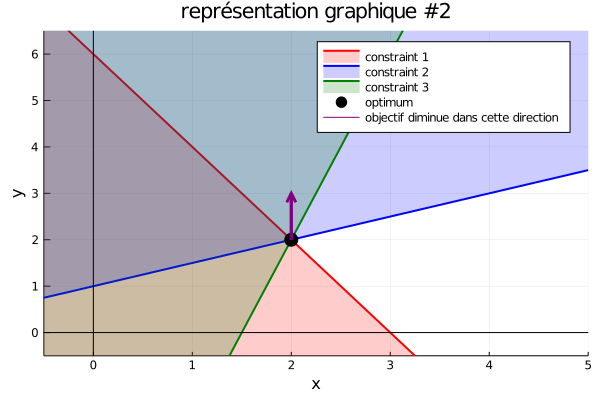

In [8]:
plot(x -> 6 - 2x, -0.5, 5, fill = (:red, 0.2, -0.5), color = :red, linewidth = 2.0, label = "constraint 1")
plot!(x -> 1 + x/2, -0.5, 5, fill = (:blue, 0.2, 7), color = :blue, linewidth = 2.0, label = "constraint 2")
plot!(x -> -6 + 4x, -0.5, 5, fill = (:green, 0.2, 7), color = :green, linewidth = 2.0, label = "constraint 3")
scatter!([2], [2], color = :black, markersize = 8.0, label = "optimum")
plot!([2, 2], [2, 3], arrow = :arrow, color = :purple, label = "objectif diminue dans cette direction", linewidth = 3)
vline!([0], color = :black, label = "")
hline!([0], color = :black, label = "")
plot!(xlims = (-0.5, 5))
plot!(ylims = (-0.5, 6.5))
plot!(xlabel = "x", ylabel = "y")
plot!(title = "représentation graphique #2")

On choisit de minimiser $z = -y$ pour que le point (2,2) soit optimale. D'autre choix sont possibles.

In [9]:
constraints = [2 1; -1 2; 4 -1]
b = [6, 2, 6]
c = [0, -1]
M = Array{Rational}([constraints I(3) b; c' zeros(Int, 4)'])

4×6 Array{Rational,2}:
  2//1   1//1  1//1  0//1  0//1  6//1
 -1//1   2//1  0//1  1//1  0//1  2//1
  4//1  -1//1  0//1  0//1  1//1  6//1
  0//1  -1//1  0//1  0//1  0//1  0//1

Sous forme standard, les contraintes deviennent
\begin{align*}
2x + y + s_1 &= 6 \\
-x + 2y - s_2 &= 2 \\
4x - y + s_3 &= 6
\end{align*}

La matrice M correspond aux tableau du simplexe. La seconde contrainte n'a pas de variable isolée, aussi il n'y a pas de base directement identifiable.


| Base | $x$ | $y$ | $s_1$ | $s_2$ | $s_3$ | $-z$ | T.D. |
|------|---|---|-------|-------|-------|------|-------|
|      | 2 | 1 |  1    |       |       | |  6    |
|      |-1 |2  |       |  -1   |       | | 1    |
|      | 4 | -1|       |       | 1     | |  6   |
|  $-z$| 0 | -1|       |       | 1     | |  0   |

On sait qu'à la solution optimale, $x=2, y = 2$, $x$ et $y$ seront donc dans la base optimale. On va les isoler.

In [10]:
pivot!(M, 1, 1)
pivot!(M, 2, 2)

4×6 Array{Rational,2}:
 1//1  0//1   2//5  -1//5  0//1  2//1
 0//1  1//1   1//5   2//5  0//1  2//1
 0//1  0//1  -7//5   6//5  1//1  0//1
 0//1  0//1   1//5   2//5  0//1  2//1

On a maintenant le tableau suivant


| Base | $x$ | $y$ | $s_1$ | $s_2$ | $s_3$ | $-z$ | T.D. |
|------|---|---|-------|-------|-------|------|-------|
|      | 1 |   |  2/5  |   -1/5    |       | |    2  |
|      |   |1  |  1/5  |  2/5   |       | |  2  |
|      |   |   |-7/5   |   6/5    |   1  | |  0   |
|  $-z$|   |   | 1/5   |   2/5    |      | |  2   |

On a 3 variables isolées, on peut donc extraire une base


| Base | $x$ | $y$ | $s_1$ | $s_2$ | $s_3$ | $-z$ | T.D. |
|------|---|---|-------|-------|-------|------|-------|
| $x$  | 1 |   |  2/5  |   -1/5    |       | |    2  |
| $y$  |   |1  |  1/5  |  2/5   |       | |  2  |
| $s_3$ |   |   |-7/5   |   6/5    |   1  | |  0   |
|  $-z$|   |   | 1/5   |   2/5    |      | |  2   |

On voit que la solution est réalisable et optimale. Néanmoins, elle ne répond pas à la question. Faisont sortir $s_3$ de la base et entrer $s_1$ pour voir



In [11]:
pivot!(M, 3, 3)

4×6 Array{Rational,2}:
 1//1  0//1  0//1   1//7   2//7  2//1
 0//1  1//1  0//1   4//7   1//7  2//1
 0//1  0//1  1//1  -6//7  -5//7  0//1
 0//1  0//1  0//1   4//7   1//7  2//1

| Base | $x$ | $y$ | $s_1$ | $s_2$ | $s_3$ | $-z$ | T.D. |
|------|---|---|-------|-------|-------|------|-------|
|   $x$   | 1 |   |  0  |    1/7   |     2/7  | |    2 |
|    $y$  |   |1  |  0  |  4/7     |    1/7   | |   2  |
|   $s_1$   |   |   |1   |   -6/7  |    -5/7  | | 0   |
|  $-z$|   |   | 0   |   4/7       |   1/7    | |  2   |

La solution est toujours réalisable et optimale, et ne répond toujours pas à la question... Faisont sortir $s_1$ de la base et entrer $s_2$.

In [12]:
pivot!(M, 3, 4)

4×6 Array{Rational,2}:
 1//1  0//1   1//6  0//1   1//6  2//1
 0//1  1//1   2//3  0//1  -1//3  2//1
 0//1  0//1  -7//6  1//1   5//6  0//1
 0//1  0//1   2//3  0//1  -1//3  2//1

| Base | $x$ | $y$ | $s_1$ | $s_2$ | $s_3$ | $-z$ | T.D. |
|------|---|---|-------|-------|-------|------|-------|
|   $x$   | 1 |   |  1/6  | 0  |     1/6  | |    2 |
|    $y$  |   |1  |  2/3  |  0 |   -1/3   | |   2  |
|   $s_2$ |   |   |  -7/6 |1   |    5/6  | | 0   |
|  $-z$   |   |   | 2/3   | 0  |    -1/3  | |  2   |

On a maintenant un objectif de 2 (qui est comme vue précédament, optimale) mais on a un coût réduit négatif.

## Question 3

Considérons le système $Ax = b$ où $A \in \mathbb{R}^{m \times n}$, $x \in \mathbb{R}^n$ et $b \in \mathbb{R}^m$. Si $rang(A) = m$, toutes les lignes de $A$ sont indépendantes, et le système admet une ou une infinité de solutions. Si $rang(A) < m$, au moins une ligne de la matrice peut s'écrire comme combinaison linéaire des autres lignes de la matrice.

Notons $a^i$ la $i^e$ ligne de la matrice et supposons que la $j^e$ ligne peut s'écrire comme combinaison linaire des autres lignes:
$$
a^j = \sum_{k \in \{1,\ldots,m\}\setminus\{j\}} \alpha_k a^k.
$$
Observons que
$$
b_j = (a^j)^Tx = \sum_{k \in \{1,\ldots,m\}\setminus\{j\}} \alpha_k (a^k)^x = \sum_{k \in \{1,\ldots,m\}\setminus\{j\}} b_k
$$
Deux cas peuvent arriver. Si
$$
b_j = \sum_{k \in \{1,\ldots,m\}\setminus\{j\}} b_k
$$
la contrainte
$$
(a^j)^Tx = b_j
$$
peut elle-même s'écrire comme combinaison linéaire des autres contraintes, et la contrainte est redondante. On peut la supprimer. Sinon la contrainte est incompatible avec les autres contraintes, et le système n'admet aucune solution.

Formons la matrice du simplexe $\begin{pmatrix} A & b \end{pmatrix}$. De ce qui précède, il suit que si $rang(A) < rang\left(\begin{pmatrix} A & b \end{pmatrix}\right)$, le système n'admet aucune solution. Sinon, si $rang(A) < m$, le système admet une ou plusieurs contraintes redondantes.

Une implémentation naïve suit.

In [13]:
function remove_constraints(A:: Matrix, b:: Vector)
    i = 1
    j = 1
    G = A[1:1,:]
    g = b[1]
    rG = rank(G)
    (m,n) = size(A)

    while (i < m)
        i += 1
        G = [G; A[i:i,:]]
        g = [g; b[i]]
        rGcand = rank(G)
        if (rGcand > rG)
            rG = rank(G)
        else
            # rGcand == rG
            # La ligne ajoutée est linéairement dépendante des autres lignes
            # On vérifie que le système est bien déterminé
            Gb = [G b[1:i]]
            if rank(Gb) > rG
                rG = -1
                break
            else
                G = G[1:j, :]
                g = g[1:j]
            end
        end
        j += 1
    end
    
    if rG == -1
        println("Le système n'admet aucune solution")
    else
        println("Le système est ", G, "x = ", g, ".")
    end

    return G, g, rG
end

remove_constraints (generic function with 1 method)

In [14]:
A = [ 2.0 5 6 ; 7 8 9 ; 4 10 12]
b = [ 1.0; 1; 1]

remove_constraints(A, b)

Le système n'admet aucune solution


([2.0 5.0 6.0; 7.0 8.0 9.0; 4.0 10.0 12.0], [1.0, 1.0, 1.0], -1)

In [15]:
b = [ 1; 1; 2]

G, g, rG = remove_constraints(A, b)

Le système est [2.0 5.0 6.0; 7.0 8.0 9.0]x = [1, 1].


([2.0 5.0 6.0; 7.0 8.0 9.0], [1, 1], 2)

Le calcul du rang d'une matrice implique une factorisation de celle-ci, ce qui est coûteux numériquement. Une solution plus efficace consiste à effectuer un pivot sur le premier élément non nul (s'il existe) de chaque ligne. Si une ligne de $A$ est combinaison linéaire des autres lignes, les opérations de pivotage conduiront à annuler tous les éléments de la ligne (comme on modifie la ligne avec une combinaison linéaire des autres lignes pour annuler l'élément dans la colonne de la ligne si elle ne correspond pas à la ligne du pivot). Il suffit alors de regarder si la composante correspondante dans le vecteur $b$ est nulle (contrainte redondante) ou non (contrainte incompatible).

In [16]:
function problemeReduce(A::Matrix{T}, b::Vector{T})::Tuple{Matrix{T}, Vector{T}} where T
    M = [A b]
    m, n = size(M)
    redondant = Int[]
    for i in 1:m
        j = findfirst(x -> x != 0, M[i, :])
        isnothing(j) ? push!(redondant, i) : pivot!(M, i, j)
        j == n && (println("problème impossible") ; return (A, b))
    end
    println(M)
    s = setdiff(1:m, redondant)
    return A[s, :], b[s]
end

problemeReduce (generic function with 1 method)

In [17]:
A = [1.0 2 1; 1 2 0; 0 0 1]
b = [1.0, 1, 0]
A1, b1 = problemeReduce(A, b)
m1, n1 = size(A1)
println(rank(A1) == 2)
println(m1 == 2)

[1.0 2.0 0.0 1.0; -0.0 -0.0 1.0 -0.0; 0.0 0.0 0.0 0.0]
true
true


In [18]:
A11 = [1 2 1; 2 3 4; 3  5  5]
A22 = [3 4 5; 4 5 5 ; 7  9  10]
A = 1//1*[A11 zeros(Int, 3,3); zeros(Int, 3,3) A22]
b = 1//1*[i for i in 1:6]
A2, b2 = problemeReduce(A, b)

problème impossible


(Rational{Int64}[1//1 2//1 … 0//1 0//1; 2//1 3//1 … 0//1 0//1; … ; 0//1 0//1 … 5//1 5//1; 0//1 0//1 … 9//1 10//1], Rational{Int64}[1//1, 2//1, 3//1, 4//1, 5//1, 6//1])

In [19]:
b = [1//1, 2, 3, 4, 5, 9]
A2, b2 = problemeReduce(A, b)

m2, n2 = size(A2)
println(rank(A2) == 4)
println(m2 == 4)

Rational{Int64}[1//1 0//1 5//1 0//1 0//1 0//1 1//1; 0//1 1//1 -2//1 0//1 0//1 0//1 0//1; 0//1 0//1 0//1 0//1 0//1 0//1 0//1; 0//1 0//1 0//1 1//1 0//1 -5//1 0//1; 0//1 0//1 0//1 0//1 1//1 5//1 1//1; 0//1 0//1 0//1 0//1 0//1 0//1 0//1]
true
true
